# Импорт библиотек

In [97]:
from random import uniform
from random import random
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

# Функция Растригина

In [98]:
@njit
def f(x: np.ndarray):  # функция Растригина от -5.12 до 5.12
    a = 10
    result = 0
    n = len(x)
    for i in range(n):
        result += x[i] ** 2 - a * np.cos(2 * np.pi * x[i])

    return a * n + result

# Реализация метода роя частиц на Python с использованием numba

In [99]:
@njit
def main(v_max: float):
    px_list: np.ndarray
    py_list: np.ndarray
    best_solution: np.ndarray
    best_coord: np.ndarray

    dimension = 2  # размерность
    r1 = np.random.rand(dimension - 1)
    r2 = np.random.rand(dimension - 1)
    weight = 3.4
    p_global_best = 1000.0
    p_best_coordinates = np.zeros(dimension - 1)

    for j in range(50):
        coordinates = np.random.uniform(-5.12, 5.12, dimension - 1)
        c1 = random()
        c2 = random()
        p_coordinates_now = np.copy(coordinates)
        p_coordinates = np.copy(coordinates)
        p = f(coordinates)
        array_of_speed = np.zeros((400, dimension - 1))

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

        for k in range(dimension - 1):
            array_of_speed[0][k] = uniform(-1 * v_max, v_max)

        for i in range(1, len(array_of_speed)):
            array_of_speed[i] = array_of_speed[i - 1] * weight + \
                                c1 * r1 * (p_best_coordinates - p_coordinates_now) + \
                                c2 * r2 * (p_best_coordinates - p_coordinates_now)

            for k in range(dimension - 1):
                if array_of_speed[i][k] > 0:
                    array_of_speed[i][k] = min(array_of_speed[i][k], v_max)
                else:
                    array_of_speed[i][k] = max(array_of_speed[i][k], v_max)

            p_coordinates_now = p_coordinates_now + array_of_speed[i]

            if p > f(p_coordinates_now):
                p = f(p_coordinates_now)
                p_coordinates = p_coordinates_now

        if j == 0:
            px_list = np.copy(coordinates)
            py_list = np.array([p])
        else:
            px_list = np.append(px_list, coordinates)
            py_list = np.append(py_list, p)

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

        if j == 0:
            best_solution = np.array([p_global_best])
            best_coord = np.copy(p_best_coordinates)
        else:
            best_solution = np.append(best_solution, p_global_best)
            best_coord = np.append(best_coord, p_best_coordinates)
    print("global_best:", p_global_best, "coordinates:", p_best_coordinates)
    print("Размерности совпадают: ", px_list.shape == py_list.shape)
    return [px_list, py_list], [best_coord, best_solution]

In [100]:
list_of_all = main(1.9)
list_of_x = list_of_all[0][0]
list_of_y = list_of_all[0][1]
list_of_best_coord = list_of_all[1][0]
list_of_best_solution = list_of_all[1][1]

global_best: 0.04816863529751103 coordinates: [-0.01558808]
Размерности совпадают:  True


[ 4.8653987   3.89870519  1.6116425   4.40318468 -1.19712041 -1.93555715
  4.92653996  0.08226582  4.18604876 -1.67023125 -4.43153254 -0.162361
 -4.05285434  3.77197178  3.4573553  -4.53547182 -1.91558808 -3.18621504
 -0.26483122 -2.24166333  4.70531277  4.07679321 -4.55848158 -1.02236608
 -4.57562149 -4.56982441 -2.48101954 -1.00284805 -4.64029063  4.21836783
 -5.10130838 -3.00077584 -4.73659409 -4.14728771 -2.38220613 -1.98620084
  3.91632509 -4.60123222  4.91280671 -3.75436895  1.67462336  2.1411345
 -3.19531509 -0.19685747  4.97279887  2.2455561  -0.44325608  2.13129018
 -4.60445712  4.47403723] 
 [27.04021538 17.15781891 20.23633175 37.5941934   8.17136793  0.24979301
 25.31722102  1.31317174 23.61208735  7.67985916  3.21297776  4.79393096
  8.90295852 22.85162449 31.59647689  6.24021692  0.04816864 13.91022213
  1.17992087 14.5014855  34.9110022  17.76189369  5.00262408  1.14381371
  4.16560106 18.5684568  15.93945241  1.00730529  1.81851223 25.82017878
 14.86165267  3.15028652  

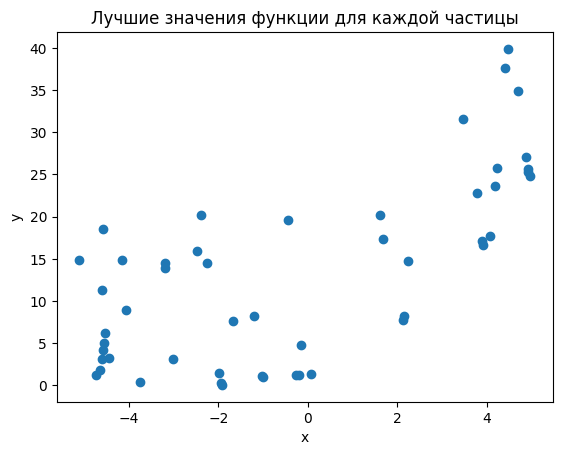

In [101]:
print(list_of_x, "\n", list_of_y)
plt.scatter(list_of_x, list_of_y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Лучшие значения функции для каждой частицы")
plt.show()

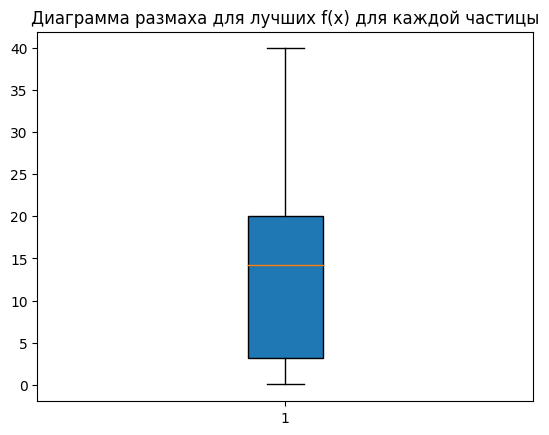

In [102]:
bp = plt.boxplot(list_of_y, patch_artist=True)  # диаграмма размаха для лучших f(x) для каждой частицы
plt.title("Диаграмма размаха для лучших f(x) для каждой частицы")
plt.show()

[ 4.8653987   3.89870519  3.89870519  3.89870519 -1.19712041 -0.03555715
 -0.03555715 -0.03555715 -0.03555715 -0.03555715 -0.03555715 -0.03555715
 -0.03555715 -0.03555715 -0.03555715 -0.03555715 -0.01558808 -0.01558808
 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808
 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808
 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808
 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808
 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808 -0.01558808
 -0.01558808 -0.01558808] 
 [27.04021538 17.15781891 17.15781891 17.15781891  8.17136793  0.24979301
  0.24979301  0.24979301  0.24979301  0.24979301  0.24979301  0.24979301
  0.24979301  0.24979301  0.24979301  0.24979301  0.04816864  0.04816864
  0.04816864  0.04816864  0.04816864  0.04816864  0.04816864  0.04816864
  0.04816864  0.04816864  0.04816864  0.04816864  0.04816864  0.04816864
  0.04816864  0.0481686

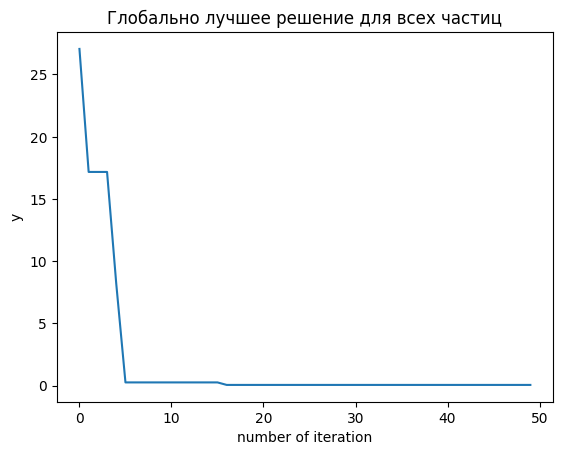

In [103]:
print(list_of_best_coord, "\n", list_of_best_solution)
plt.plot(np.arange(list_of_best_solution.size), list_of_best_solution)
plt.xlabel("number of iteration")
plt.ylabel("y")
plt.title("Глобально лучшее решение для всех частиц")
plt.show()